In [ ]:
import sys
sys.path.append('/home/rwb/github/skaworkflows')

import logging
import json

from pathlib import Path


logging.basicConfig(level='INFO')
LOGGER = logging.getLogger(__name__)
%pwd 


In [ ]:
system_config_path = Path('workflow_data_allocation/no_data_low_sdp_config_prototype_n896_896channels.json')

with open(system_config_path) as fp: 
    system_config = json.load(fp)

flops,compute_bandwidth,memory = system_config['cluster']['system']['resources']['GenericSDP_m0'].values()
print(flops/10**12, compute_bandwidth/10**9)


In [ ]:
# Setup multipler for a given observation
obs_time = 18000
compute_unit = 10**15 # Peta flop
data_unit = 10**6 # per million visibilites 
bytes_per_vis = 12 

In [166]:
# Isolate a single unit of computing 

import pandas as pd
workflows = ['ICAL', 'DPrepA','DPrepB','DPrepC','DPrepD']
low_hpsos = ['hpso01', 'hpso02a', 'hpso02b']


# structure the data according to | product | workflow | time | type (long-form data) rather than wide form

df = pd.DataFrame()

for wf in workflows: 
    for hpso in low_hpsos:
        workflow_data_path = Path(
            f"low/prototype/workflows/data_overview/{hpso}_time-18000_channels-896_tel-512.json_{wf}_data"
        )
        with open(workflow_data_path) as fp: 
            workflow_data = json.load(fp)

        for product in workflow_data:
            columns = {'HPSO': hpso, 'Product': product, 'Workflow': wf, 'Time (s)': [], 'Type': []}
            curr_product_dict = workflow_data[product]
            if 'total_compute' in workflow_data[product]:
                compute = curr_product_dict['fraction_compute_cost']  * obs_time * compute_unit
                columns['Time (s)'].append(compute / flops)
                columns['Type'].append('compute')
                data = curr_product_dict['fraction_data_cost'] * obs_time * data_unit * bytes_per_vis
                columns['Time (s)'].append(data / compute_bandwidth)
                columns['Type'].append('data')
            tmp_df = pd.DataFrame(columns,)
            df = df.append(tmp_df, ignore_index=True)

In [311]:
# df[df["HPSO"] == 'hpso02b']
df = df.loc[(df!=0).all(1)]
products = set(df["Product"])
products

{'Correct',
 'Degrid',
 'FFT',
 'Flag',
 'Grid',
 'IFFT',
 'Predict',
 'Solve',
 'Subtract',
 'UpdateLSM'}

In [339]:

grouped = df.groupby(["HPSO", "Product"])

# for name, group in grouped:
# #     print(name)
# #     print(group)
    
# df_grouped_ex = grouped.get_group(("hpso01", "Correct"))
# mask = df_grouped_ex['HPSO']== df_grouped_ex['HPSO']
# mid_group = df_grouped_ex.groupby(["Type"])

# mid_group.get_group("data")
# for name, group in mid_group:
#     print(name)
#     print(group)

# min_time = min(
#     grouped.get_group(("hpso01", "Correct", "compute")).min()['Time (s)'],
#     grouped.get_group(("hpso01", "Correct", "data")).min()['Time (s)']
# )
# max_time = 
# df_grouped_ex.loc[:, "rank"] = df_grouped_ex.max()["Time (s)"] - df_grouped_ex.min()["Time (s)"]
# df_grouped_ex

hpso_dataframes = {}
for h in low_hpsos:
    df_hpso = df[df["HPSO"] == h]
    grouped = df_hpso.groupby("Product")
    grouped_df = []
    
    for p in products:
        if p not in grouped.groups.keys():
            continue
        df_grouped_ex = grouped.get_group(p)
        tmp_group = df_grouped_ex.groupby(["Type"])
        min_time = min(
            tmp_group.get_group("data").min()["Time (s)"],
            tmp_group.get_group("compute").min()["Time (s)"] 
        )
        max_time = max(
            tmp_group.get_group("data").max()["Time (s)"],
            tmp_group.get_group("compute").max()["Time (s)"] 
        )
        df_grouped_ex.loc[:, "rank"] = max_time-min_time
        grouped_df.append(df_grouped_ex)
    if grouped_df:
        hpso_dataframes[h] = pd.concat(grouped_df, ignore_index=True)

hpso_dataframes['hpso01'] = hpso_dataframes['hpso01'].sort_values(by=['rank','Product'], ascending=False)
# hpso_dataframes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))


fig.supxlabel('Product', y=-0.1), fig.supylabel('Time (s)')

# Look into representing this as something like a distribution across all workflows
# Seaborn categorical scatterplots could be a good start: https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots

x_label = df['product']
x_compute = df['compute']/(flops)
x_data = df['data']/(compute_bandwidth)
x = np.arange(0, 2*len(x_label), step=2)

ax.bar(x - 0.5, x_compute,log=True,zorder=1)
ax.bar(x + 0.5, x_data)
ax.set_xticks(x, x_label,rotation='vertical')
ax.tick_params(right=True, top=True, which='both', direction='in')
plt.savefig('output.png')

/tmp/ipykernel_67455/4036947769.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_67455/4036947769.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_67455/4036947769.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_67455/4036947769.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two m

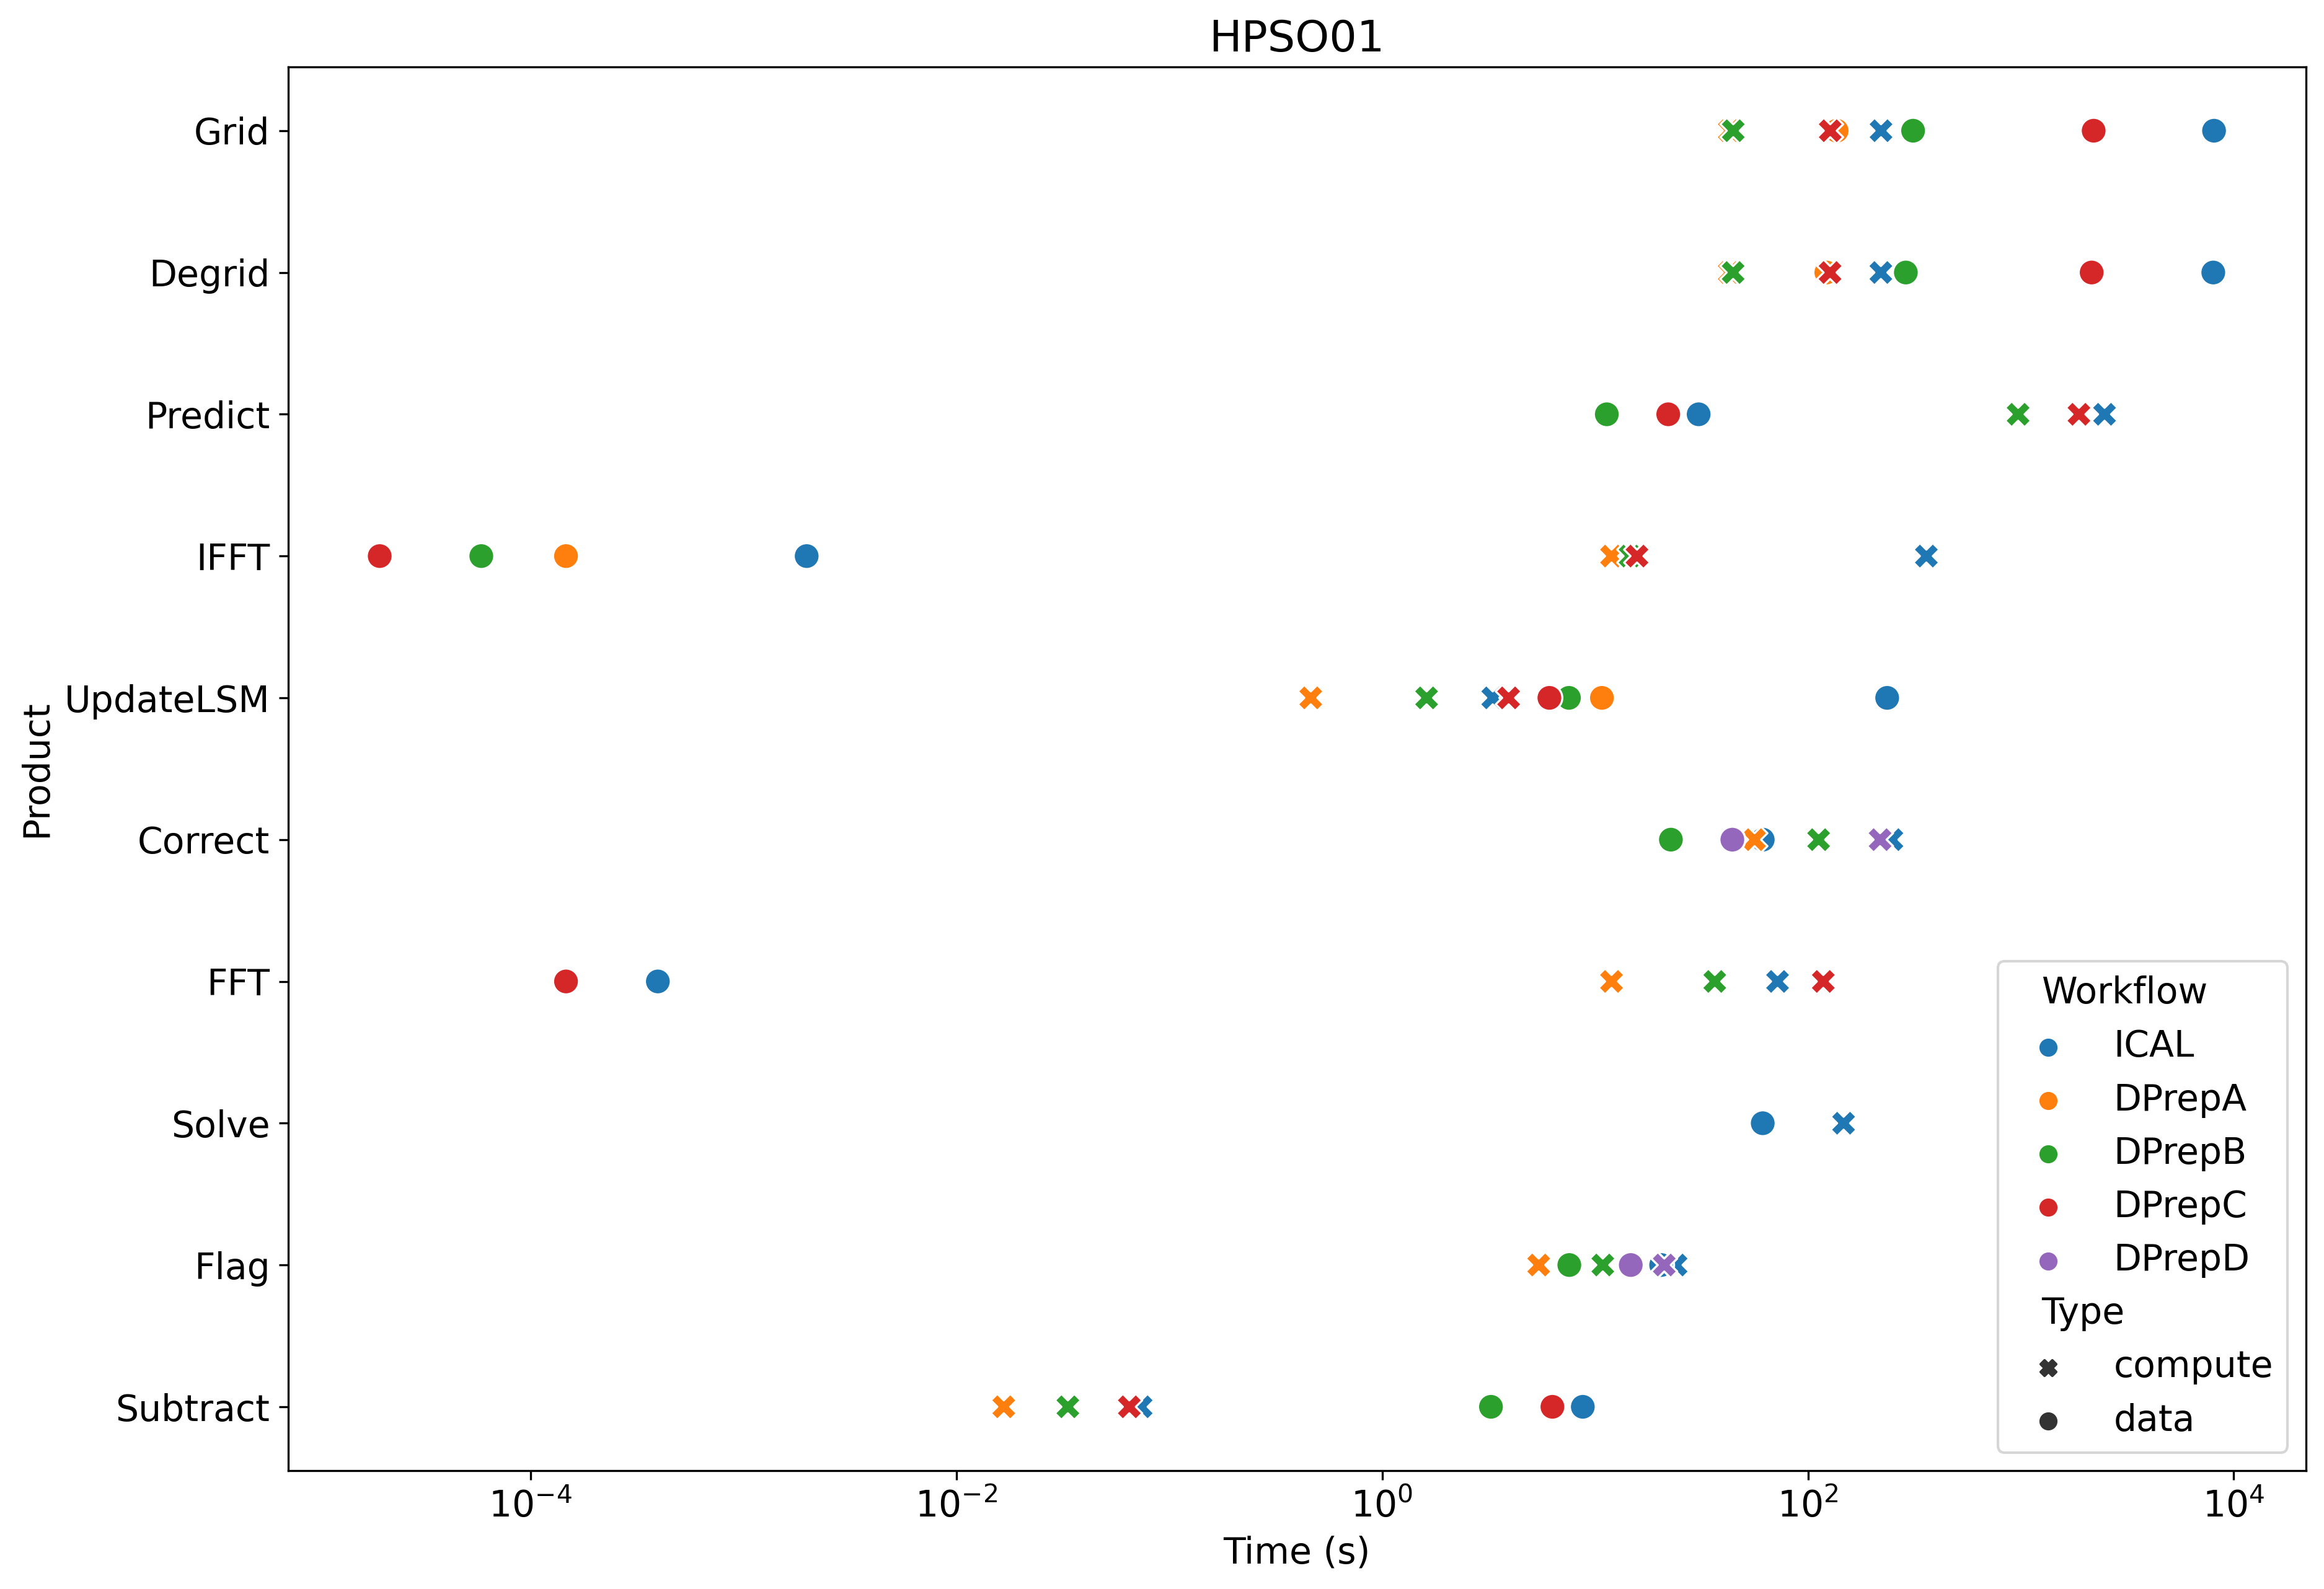

In [416]:
# For categorical plot, we want to reshape the data so the time is either compute or data
# i.e. rather than Product| workflow | Data time | compute time | , we have | product | workflow | time | type 
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(14,10),dpi=300)

hpso = 'hpso01'
df = hpso_dataframes[hpso]

df_comp = df[df['Type']== 'compute']
df_data = df[df['Type']== 'data']

g = sns.scatterplot(df, y='Product', x='Time (s)', hue='Workflow', style='Type', markers=['X', 'o'], s=100,)
# g = sns.catplot(df_data, y='Product', x='Time (s)', hue='Workflow', s=8, jitter=False, marker='P')
g.set_xscale("log")
# g.set_facecolor("none")
ax.set_title("HPSO01")
# for ax in g.fig.axes:
#     ax.set_xscale("log")

plt.savefig("HPSORuntimeComparison.png")

In [ ]:
Rvis = 592420
(Rvis *10**6 * 18000 * 12)/3500/compute_bandwidth/60

1.038693e+16/flops/60